# In this script, I Experiment with the Cifar-10 dataset. Moreover, I will transfer the AANN modifications to conv-deconv autoencoder architecture.
-------------------------------------------------------------------------------------------------------------------
### Technology used: Tensorflow-core 

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
from six.moves import cPickle as pickle # for reading the data
import matplotlib.pyplot as plt # for visualization
import numpy as np
from sklearn.preprocessing import OneHotEncoder # for encoding the labels in one hot form

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
LICENSE
Literature_survey
Models
README.md
Res
Scripts



In [4]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../../Data/cifar-10" # the data path
train_meta = os.path.join(data_path, "batches.meta")
idea = "IDEA_1"
base_model_path = '../../Models'
idea_model_path = os.path.join(base_model_path, idea)

# constant values:
size = 32 # the images of size 32 x 32
channels = 3 # RGB channels
highest_pixel_value = 255.0 # 8 bits for every channel. So, max value is 255
no_of_epochs = 100 # No. of epochs to run
no_of_batches = 5 # There are 5 batches in the dataset
checkpoint_factor = 5 # save the model after every 5 steps (epochs)
num_classes = 10 # There are 10 different classes in the dataset
k_size = 5 # all kernels are 5x5
n_hidden_neurons_in_fc_layers = 512
representation_vector_length = 128 # length of the mid_level representation vector
batch_size = 128 # we look at 5000 images at a time

In [5]:
# check the contents inside the data folder
exec_command(['ls', data_path])

batches.meta
data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
readme.html
test_batch



In [6]:
# function to unPickle a file: 
def unpickle(file):
    '''
        This function takes the file path and unPickles the file acquired from it
        @Param file: the string path of the file
        @return: The dict object unPickled from the file
    '''
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

### Let's check the contents of the batches.meta file

In [7]:
meta_data = unpickle(train_meta)

# check it's contents
meta_data

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

### Let's read and display some of the images from the dataset along with their labels

In [8]:
train_batch_preliminary = unpickle(os.path.join(data_path, "data_batch_3"))

# check it's contents
train_batch_preliminary.keys()

['data', 'labels', 'batch_label', 'filenames']

In [9]:
# Extract the first 3 images from the dataset
preliminary_data = train_batch_preliminary['data'].reshape((len(train_batch_preliminary['data']), 32, 32, 3), 
                                                           order='F')
preliminary_labels = train_batch_preliminary['labels']

# view some of the data:
preliminary_data[33, :10, :10, 2] #(10 x 10) data of blue channel of 33rd image

array([[178, 191, 193, 197, 202, 206, 207, 209, 214, 219],
       [140, 151, 155, 160, 166, 172, 173, 171, 176, 180],
       [ 84,  94, 119, 151, 146, 127, 125, 135, 139, 139],
       [ 16,  18,  85, 200, 207, 133,  71,  59,  72,  79],
       [  9,   3,  51, 183, 238, 219, 177,  94,  30,  16],
       [ 31,  25,  38, 148, 240, 249, 255, 235, 139,  39],
       [ 69,  65,  62, 115, 215, 250, 248, 253, 245, 201],
       [ 92,  89,  81,  89, 173, 240, 249, 253, 253, 255],
       [ 93,  90,  84,  85, 139, 217, 241, 246, 251, 252],
       [ 75,  74,  71,  87, 154, 208, 229, 239, 245, 250]], dtype=uint8)

In [10]:
# check a few values of the labels of the dataset
preliminary_labels[:10] 

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2]

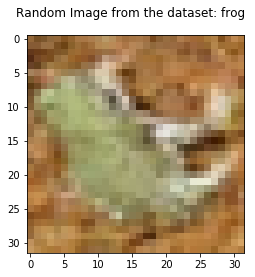

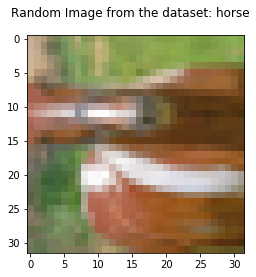

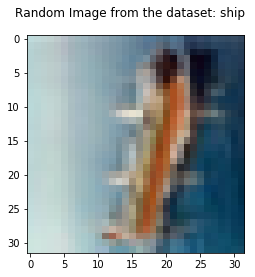

In [11]:
for _ in range(3):
    random_index = np.random.randint(preliminary_data.shape[0])
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
    plt.imshow(preliminary_data[random_index], interpolation='none')

### The images look blurred out because they are very low resolution images (32 x 32) pixels only.

## It can be seen that the images in the original dataset are skewed. So, we will have to rotate them by 90 degrees clockwise

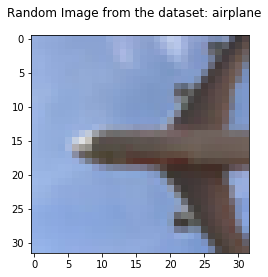

In [12]:
# let's try using the numpy.rot90 method for this:
random_index = np.random.randint(preliminary_data.shape[0])
    
plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
plt.imshow(np.rot90(preliminary_data[random_index], axes=(1, 0)), interpolation='none'); # suppress the unnecessary
# output

This works. So, now we can create a function to put all this together. This function would take the batch pickle file and create the data suitable for feeding it off to a convolutional neural network.

In [13]:
# The batch generator function:
def generateBatch(batchFile):
    '''
        The function to generate a batch of data suitable for performing the convNet operations on it
        @param batchFile -> the path of the input batchfile
        @return batch: (data, labels) -> the processed data.
    '''
    # unpickle the batch file:
    data_dict = unpickle(batchFile)
    
    # extract the data and labels from this dictionary
    unprocessed_data = data_dict['data']
    integer_labels = np.array(data_dict['labels']) # labels in integer form
    
    # reshape and rotate the data
    data = unprocessed_data.reshape((len(unprocessed_data), size, size, channels), order='F')
    processed_data = np.array(map(lambda x: np.rot90(x, axes=(1, 0)), data))
    
    # normalize the images by dividing all the pixels by 255
    # processed_data = processed_data.astype(np.float32) / highest_pixel_value
    
    # encode the labels in one-hot encoded form
    # we use the sklearn.preprocessing package for doing this
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = np.array(encoder.fit_transform(integer_labels.reshape(len(integer_labels), 1)))
    
    # return the processed data and the encoded_labels:
    return (processed_data, encoded_labels)

### Time to test this function

In [14]:
# load the batch no. 1 and check if it works correctly.
batch_data, batch_labels = generateBatch(os.path.join(data_path, "data_batch_1"))
print (batch_data.shape, batch_labels.shape)

# batch_data[0, :12, :12, 2]

((10000, 32, 32, 3), (10000, 10))


Random image shape: (32, 32, 3)
Random image dataTypeuint8


check if the data has been properly normalized
[[143 146 144]
 [165 167 164]
 [155 157 160]]


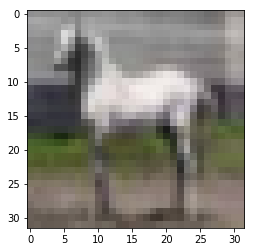

In [15]:
# extract one image from the data and display it
randomIndex = np.random.randint(batch_data.shape[0])
randomImage = batch_data[randomIndex]
print "Random image shape: " + str(randomImage.shape)

print "Random image dataType" + str(randomImage.dtype)

print "\n\ncheck if the data has been properly normalized"
print randomImage[:3, :3, 0]

# Visualize the random image from the dataset
plt.figure()
plt.imshow(randomImage, interpolation='none'); # suppress the unnecessary

Alright! So, the data extraction module is setup. Let's move on to the actual model building and training.

# Define the computation graph. This uses a conv-deconv network for the ANN concept

### define the placeholders for the computations:

In [16]:
# point to reset the graph:
tf.reset_default_graph()

In [17]:
with tf.variable_scope("Placeholders"):
    tf_input = tf.placeholder(tf.float32, shape=(None, size, size, channels), name="inputs")
    
    # add an image summary for the tf_input
    tf_input_summary = tf.summary.image("Input_images", tf_input)
    
    tf_labels = tf.placeholder(tf.float32, shape=(None, num_classes), name="labels")
    # this is to send in the representation vector tweaked by us to generate images that we want
    tf_representation_vector = tf.placeholder(tf.float32, shape=(None, num_classes), name="representation") 

In [18]:
# print all these tensors to check if they have been correctly defined
tf_input, tf_labels, tf_representation_vector
# all look good

(<tf.Tensor 'Placeholders/inputs:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Placeholders/labels:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Placeholders/representation:0' shape=(?, 10) dtype=float32>)

### define the kernel and bias variables used for the computation. I am defining them separately instead of using the layers api from the latest tensorflow because I am going to use the same weights while deconvolving the representations (Use of tied weights).

In [19]:
with tf.variable_scope("Weights_and_biases"):
    # special b0 for the input images to be added when performing the backward computations
    b0 = tf.get_variable("b0", shape=(1, size, size, channels), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # normal kernel weights and biases
    w1 = tf.get_variable("W1", shape=(k_size, k_size, channels, 4), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b1 = tf.get_variable("b1", shape=(1, 16, 16, 4), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w2 = tf.get_variable("W2", shape=(k_size, k_size, 4, 8), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b2 = tf.get_variable("b2", shape=(1, 8, 8, 8), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w3 = tf.get_variable("W3", shape=(k_size, k_size, 8, 16), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b3 = tf.get_variable("b3", shape=(1, 4, 4, 16), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w4 = tf.get_variable("W4", shape=(k_size, k_size, 16, 32), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b4 = tf.get_variable("b4", shape=(1, 2, 2, 32), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # two more weights and biases for the final fully connected layers
    
    w_fc1 = tf.get_variable("W_fc1", shape=(representation_vector_length, n_hidden_neurons_in_fc_layers), 
                            dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc1 = tf.get_variable("b_fc1", shape=(1, n_hidden_neurons_in_fc_layers), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w_fc2 = tf.get_variable("W_fc2", shape=(n_hidden_neurons_in_fc_layers, num_classes), dtype=tf.float32, 
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc2 = tf.get_variable("b_fc2", shape=(1, num_classes), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    

### define the forward computations

In [20]:
# define a function for the forward_computations (named as encode)
def encode(inp):
    '''
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to encode the given input images into the final num_classes-dimensional representation vector
        @param
        inp => tensor corresponding to batch of input images
        @return => tensor of shape [batch_size x num_classes] 
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the convolution layers:
    z1 = tf.nn.conv2d(inp, w1, stride_pattern, padding_pattern) + b1
    a1 = tf.abs(z1)
    
    z2 = tf.nn.conv2d(a1, w2, stride_pattern, padding_pattern) + b2
    a2 = tf.abs(z2)
    
    z3 = tf.nn.conv2d(a2, w3, stride_pattern, padding_pattern) + b3
    a3 = tf.abs(z3)
    
    z4 = tf.nn.conv2d(a3, w4, stride_pattern, padding_pattern) + b4
    a4 = tf.abs(z4)
    
    # reshape the a4 activation map:
    fc_inp = tf.reshape(a4, shape=(-1, representation_vector_length))
    
    assert fc_inp.shape[-1] == representation_vector_length, "mid_level_representation_vector isn't 128 dimensional"
    
    # define the fully connected layers:
    
    z_fc1 = tf.matmul(fc_inp, w_fc1) + b_fc1
    a_fc1 = tf.abs(z_fc1)
    
    z_fc2 = tf.matmul(a_fc1, w_fc2) + b_fc2
    a_fc2 = tf.abs(z_fc2)
    
    assert a_fc2.shape[-1] == num_classes, "final_representation_vector isn't 10 dimensional"
    
    # if everything is fine, return the final activation vectors:
    return a_fc2, tf.shape(a1), tf.shape(a2), tf.shape(a3)

In [21]:
with tf.variable_scope("Encoder"):
    y_, sha1, sha2, sha3 = encode(tf_input)

In [22]:
# check the type of y_ 
print y_
# looks good alright!

Tensor("Encoder/Abs_5:0", shape=(?, 10), dtype=float32)


### define the backward computations

In [23]:
def decode(inp, sha1, sha2, sha3):
    ''' 
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to decode the given input representation vector into 
        the size - dimensional images that should be as close as possible
        @param
        inp => tensor corresponding to batch of representation vectors
        @return => tensor of shape [batch_size x size x size x channels]
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the backward pass through the fully connected layers:
    z_b_1 = tf.matmul(inp, tf.transpose(w_fc2)) + b_fc1
    a_b_1 = tf.abs(z_b_1)
    
    z_b_2 = tf.matmul(a_b_1, tf.transpose(w_fc1)) + tf.reshape(b4, shape=(1, -1))
    a_b_2 = tf.abs(z_b_2)
    
    assert a_b_2.shape[-1] == representation_vector_length, "reverse_pass: vector not 128 dimensional"
    
    # reshape the vector into a feature map:
    dconv_in = tf.reshape(a_b_2, shape=(-1, 2, 2, 32)) # reshape into 2x2 maps
    
    # define the deconvolution operations
    z_b_dconv_1 = tf.nn.conv2d_transpose(dconv_in, w4, sha3, 
                                         stride_pattern, padding_pattern) + b3
    a_b_dconv_1 = tf.abs(z_b_dconv_1)

    
    z_b_dconv_2 = tf.nn.conv2d_transpose(a_b_dconv_1, w3, sha2,
                                        stride_pattern, padding_pattern) + b2
    a_b_dconv_2 = tf.abs(z_b_dconv_2)    
    
    
    z_b_dconv_3 = tf.nn.conv2d_transpose(a_b_dconv_2, w2, sha1,
                                        stride_pattern, padding_pattern) + b1
    a_b_dconv_3 = tf.abs(z_b_dconv_3)
    
    
    z_b_dconv_4 = tf.nn.conv2d_transpose(a_b_dconv_3, w1, tf.shape(tf_input),
                                        stride_pattern, padding_pattern) + b0
    a_b_dconv_4 = tf.abs(z_b_dconv_4)
    
    # return the final computed image:
    return a_b_dconv_4

In [24]:
with tf.variable_scope("Decoder"):
    x_ = decode(y_, sha1, sha2, sha3)
    
    # add the image summary for the x_ tensor
    x__summary = tf.summary.image("Network_generated_image", x_)

In [25]:
# check if the x_ is a good tensor
print x_
# looks good

Tensor("Decoder/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [26]:
# define the decoder predictions:
with tf.variable_scope("Decoder_predictions"):
    generated_image = decode(tf_representation_vector, sha1, sha2, sha3)

In [27]:
# check sanity of the generated_image
print generated_image
# looks good! :)

Tensor("Decoder_predictions/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [28]:
# define the predictions generated by the network in the forward direction:
def direction_cosines(vector):
    '''
        function to calculate the direction cosines of the given batch of input vectors
        @param
        vector => activations tensor 
        @return => the direction cosines of x
    '''
    sqr = tf.square(vector)
    div_val = tf.sqrt(tf.reduce_sum(sqr, axis=1, keep_dims=True))
    
    # return the direction cosines of the vector:
    return vector / div_val

# use this function to define the predictions:
with tf.variable_scope("Predictions"):
    predictions = direction_cosines(y_)

In [29]:
predictions

<tf.Tensor 'Predictions/div:0' shape=(?, 10) dtype=float32>

## Time to define the costs:
### Forward cost:

In [30]:
with tf.variable_scope("Forward_cost"):
    fwd_cost = tf.reduce_mean(tf.abs(predictions - tf_labels))
    
    # add scalar summary for the fwd_cost
    fwd_cost_summary = tf.summary.scalar("Forward_cost", fwd_cost)

### Backward cost:

In [31]:
with tf.variable_scope("Backward_cost"):
    bwd_cost = tf.reduce_mean(tf.abs(x_ - tf_input))
    
    # add a scalar summary for the bwd_cost
    bwd_cost_summary = tf.summary.scalar("Backward_cost", bwd_cost)

## Define the final cost and the training step:

In [32]:
with tf.variable_scope("Final_cost"):
    cost = fwd_cost + bwd_cost
    
    # add a scalar summary
    cost_summary = tf.summary.scalar("Final_cost", cost)

In [33]:
with tf.variable_scope("Trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_step = optimizer.minimize(cost) # minimize the final cost

## Perform the init and summary errands:

In [34]:
with tf.variable_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

# Create a tensorboard writer and visualize this graph before starting the training loop

In [35]:
model_path = os.path.join(idea_model_path, "Model_cifar_4")

## Now, let's write the session code to run this computation graph and perform the training

In [36]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session() as sess:
    
    tensorboard_writer = tf.summary.FileWriter(logdir=model_path, graph=sess.graph)
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model1
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    g_step = 0
    for ep in range(no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = batch_size 
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(int(np.ceil(float(len(batch_images)) / min_batch_size))):
                start = index * min_batch_size
                end = start + min_batch_size
                minX = batch_images[start: end]; minY = batch_labels[start: end]
                
                _, loss = sess.run([train_step, cost], feed_dict={tf_input: minX, tf_labels: minY})
                
                if(index % 35 ==0):
                    print('range:{} loss= {}'.format((start, end), loss))
            
                g_step += 1
                
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0 or ep == 0):
            
            # calculate the summaries:
            sums = sess.run(all_summaries, feed_dict={tf_input: minX, tf_labels: minY})
            
            # add the summaries to the fileWriter
            tensorboard_writer.add_summary(sums, global_step = g_step)
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, "model_cifar_4"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

epoch: 1
current_batch: 1
range:(0, 128) loss= 267291648.0
range:(4480, 4608) loss= 8623714.0
range:(8960, 9088) loss= 1766394.625


current_batch: 2
range:(0, 128) loss= 1795680.125
range:(4480, 4608) loss= 894263.8125
range:(8960, 9088) loss= 844786.5


current_batch: 3
range:(0, 128) loss= 907631.0625
range:(4480, 4608) loss= 693906.75
range:(8960, 9088) loss= 544853.25


current_batch: 4
range:(0, 128) loss= 529674.25
range:(4480, 4608) loss= 460250.1875
range:(8960, 9088) loss= 975004.25


current_batch: 5
range:(0, 128) loss= 753818.625
range:(4480, 4608) loss= 527953.125
range:(8960, 9088) loss= 259654.671875


epoch: 2
current_batch: 1
range:(0, 128) loss= 373265.6875
range:(4480, 4608) loss= 664563.75
range:(8960, 9088) loss= 1212874.625


current_batch: 2
range:(0, 128) loss= 1113232.25
range:(4480, 4608) loss= 460812.84375
range:(8960, 9088) loss= 173186.234375


current_batch: 3
range:(0, 128) loss= 188721.578125
range:(4480, 4608) loss= 125827.070312
range:(8960, 9088) los

current_batch: 2
range:(0, 128) loss= 80567.015625
range:(4480, 4608) loss= 70432.0234375
range:(8960, 9088) loss= 45871.1835938


current_batch: 3
range:(0, 128) loss= 39345.4882812
range:(4480, 4608) loss= 30599.0039062
range:(8960, 9088) loss= 14814.7666016


current_batch: 4
range:(0, 128) loss= 13273.5859375
range:(4480, 4608) loss= 11079.5097656
range:(8960, 9088) loss= 39075.8867188


current_batch: 5
range:(0, 128) loss= 61992.6875
range:(4480, 4608) loss= 91410.4609375
range:(8960, 9088) loss= 41985.7460938


epoch: 8
current_batch: 1
range:(0, 128) loss= 46783.4179688
range:(4480, 4608) loss= 37366.1484375
range:(8960, 9088) loss= 16341.0078125


current_batch: 2
range:(0, 128) loss= 19731.5429688
range:(4480, 4608) loss= 19386.7070312
range:(8960, 9088) loss= 38637.9648438


current_batch: 3
range:(0, 128) loss= 41895.1679688
range:(4480, 4608) loss= 34853.5351562
range:(8960, 9088) loss= 35539.625


current_batch: 4
range:(0, 128) loss= 57057.5429688
range:(4480, 4608) loss



current_batch: 4
range:(0, 128) loss= 3190.51977539
range:(4480, 4608) loss= 3781.72509766
range:(8960, 9088) loss= 10470.2763672


current_batch: 5
range:(0, 128) loss= 16109.7138672
range:(4480, 4608) loss= 15835.59375
range:(8960, 9088) loss= 8262.1171875


epoch: 14
current_batch: 1
range:(0, 128) loss= 5153.44140625
range:(4480, 4608) loss= 5131.14404297
range:(8960, 9088) loss= 3978.93920898


current_batch: 2
range:(0, 128) loss= 4146.02832031
range:(4480, 4608) loss= 3580.61376953
range:(8960, 9088) loss= 2381.92163086


current_batch: 3
range:(0, 128) loss= 2289.75805664
range:(4480, 4608) loss= 2162.88720703
range:(8960, 9088) loss= 124557.484375


current_batch: 4
range:(0, 128) loss= 421929.03125
range:(4480, 4608) loss= 50099.2226562
range:(8960, 9088) loss= 20187.4199219


current_batch: 5
range:(0, 128) loss= 19076.7832031
range:(4480, 4608) loss= 13124.2119141
range:(8960, 9088) loss= 10837.5341797


epoch: 15
current_batch: 1
range:(0, 128) loss= 9917.71582031
range:

current_batch: 5
range:(0, 128) loss= 1031.2052002
range:(4480, 4608) loss= 702.45880127
range:(8960, 9088) loss= 709.117126465


epoch: 20
current_batch: 1
range:(0, 128) loss= 718.481872559
range:(4480, 4608) loss= 662.861206055
range:(8960, 9088) loss= 697.427734375


current_batch: 2
range:(0, 128) loss= 938.337646484
range:(4480, 4608) loss= 476.832489014
range:(8960, 9088) loss= 441.454986572


current_batch: 3
range:(0, 128) loss= 647.574523926
range:(4480, 4608) loss= 473.841247559
range:(8960, 9088) loss= 382.968048096


current_batch: 4
range:(0, 128) loss= 420.488342285
range:(4480, 4608) loss= 766.278442383
range:(8960, 9088) loss= 750.99798584


current_batch: 5
range:(0, 128) loss= 906.19909668
range:(4480, 4608) loss= 1950.20544434
range:(8960, 9088) loss= 735.494506836


epoch: 21
current_batch: 1
range:(0, 128) loss= 661.565063477
range:(4480, 4608) loss= 446.810180664
range:(8960, 9088) loss= 263.46697998


current_batch: 2
range:(0, 128) loss= 506.956085205
range:(44

current_batch: 1
range:(0, 128) loss= 7796.98193359
range:(4480, 4608) loss= 7407.18847656
range:(8960, 9088) loss= 6184.32373047


current_batch: 2
range:(0, 128) loss= 7014.57910156
range:(4480, 4608) loss= 6036.45654297
range:(8960, 9088) loss= 4750.75244141


current_batch: 3
range:(0, 128) loss= 6117.52490234
range:(4480, 4608) loss= 5382.36523438
range:(8960, 9088) loss= 4471.76416016


current_batch: 4
range:(0, 128) loss= 6425.85791016
range:(4480, 4608) loss= 4465.45751953
range:(8960, 9088) loss= 3814.51855469


current_batch: 5
range:(0, 128) loss= 5042.17529297
range:(4480, 4608) loss= 4428.55712891
range:(8960, 9088) loss= 3558.74853516


epoch: 27
current_batch: 1
range:(0, 128) loss= 5735.53271484
range:(4480, 4608) loss= 3143.05859375
range:(8960, 9088) loss= 3657.3605957


current_batch: 2
range:(0, 128) loss= 5829.9296875
range:(4480, 4608) loss= 3356.35424805
range:(8960, 9088) loss= 4894.51025391


current_batch: 3
range:(0, 128) loss= 5145.31445312
range:(4480, 460

range:(8960, 9088) loss= 1169.30175781


current_batch: 3
range:(0, 128) loss= 1097.78210449
range:(4480, 4608) loss= 1705.57946777
range:(8960, 9088) loss= 813.482421875


current_batch: 4
range:(0, 128) loss= 1286.97583008
range:(4480, 4608) loss= 1357.11157227
range:(8960, 9088) loss= 1115.38330078


current_batch: 5
range:(0, 128) loss= 1324.30993652
range:(4480, 4608) loss= 1123.4510498
range:(8960, 9088) loss= 2434.94311523


epoch: 33
current_batch: 1
range:(0, 128) loss= 1859.1628418
range:(4480, 4608) loss= 2427.97802734
range:(8960, 9088) loss= 1091.49719238


current_batch: 2
range:(0, 128) loss= 1154.39758301
range:(4480, 4608) loss= 1330.12817383
range:(8960, 9088) loss= 1007.72619629


current_batch: 3
range:(0, 128) loss= 1552.66186523
range:(4480, 4608) loss= 1863.56933594
range:(8960, 9088) loss= 926.629882812


current_batch: 4
range:(0, 128) loss= 829.303100586
range:(4480, 4608) loss= 1816.48083496
range:(8960, 9088) loss= 2909.88598633


current_batch: 5
range:(0, 

current_batch: 4
range:(0, 128) loss= 248.430862427
range:(4480, 4608) loss= 233.466079712
range:(8960, 9088) loss= 256.119232178


current_batch: 5
range:(0, 128) loss= 302.947235107
range:(4480, 4608) loss= 361.649902344
range:(8960, 9088) loss= 400.508728027


epoch: 39
current_batch: 1
range:(0, 128) loss= 1040.93884277
range:(4480, 4608) loss= 500.289733887
range:(8960, 9088) loss= 261.522583008


current_batch: 2
range:(0, 128) loss= 272.744842529
range:(4480, 4608) loss= 209.471694946
range:(8960, 9088) loss= 847.362854004


current_batch: 3
range:(0, 128) loss= 639.206787109
range:(4480, 4608) loss= 361.056060791
range:(8960, 9088) loss= 248.189117432


current_batch: 4
range:(0, 128) loss= 199.36807251
range:(4480, 4608) loss= 228.414962769
range:(8960, 9088) loss= 467.555358887


current_batch: 5
range:(0, 128) loss= 287.274719238
range:(4480, 4608) loss= 172.48500061
range:(8960, 9088) loss= 156.050674438


epoch: 40
current_batch: 1
range:(0, 128) loss= 401.962402344
range:

range:(8960, 9088) loss= 174.657546997


epoch: 45
current_batch: 1
range:(0, 128) loss= 178.243484497
range:(4480, 4608) loss= 157.385025024
range:(8960, 9088) loss= 145.90284729


current_batch: 2
range:(0, 128) loss= 140.875366211
range:(4480, 4608) loss= 129.699325562
range:(8960, 9088) loss= 129.307342529


current_batch: 3
range:(0, 128) loss= 120.815742493
range:(4480, 4608) loss= 129.296096802
range:(8960, 9088) loss= 125.521881104


current_batch: 4
range:(0, 128) loss= 123.136108398
range:(4480, 4608) loss= 112.455780029
range:(8960, 9088) loss= 106.325737


current_batch: 5
range:(0, 128) loss= 103.414413452
range:(4480, 4608) loss= 101.51915741
range:(8960, 9088) loss= 96.9001159668


epoch: 46
current_batch: 1
range:(0, 128) loss= 109.39390564
range:(4480, 4608) loss= 98.3213119507
range:(8960, 9088) loss= 100.577697754


current_batch: 2
range:(0, 128) loss= 97.8301010132
range:(4480, 4608) loss= 94.7309341431
range:(8960, 9088) loss= 95.9284286499


current_batch: 3
rang

current_batch: 1
range:(0, 128) loss= 76.2765655518
range:(4480, 4608) loss= 76.7048034668
range:(8960, 9088) loss= 77.3788146973


current_batch: 2
range:(0, 128) loss= 76.1283340454
range:(4480, 4608) loss= 77.7701416016
range:(8960, 9088) loss= 76.3559494019


current_batch: 3
range:(0, 128) loss= 74.5019226074
range:(4480, 4608) loss= 77.3945007324
range:(8960, 9088) loss= 74.5099182129


current_batch: 4
range:(0, 128) loss= 78.3973388672
range:(4480, 4608) loss= 75.4322357178
range:(8960, 9088) loss= 76.9816589355


current_batch: 5
range:(0, 128) loss= 74.7520446777
range:(4480, 4608) loss= 74.2949752808
range:(8960, 9088) loss= 73.3813171387


epoch: 52
current_batch: 1
range:(0, 128) loss= 73.8689193726
range:(4480, 4608) loss= 76.1331787109
range:(8960, 9088) loss= 76.4969940186


current_batch: 2
range:(0, 128) loss= 75.0103759766
range:(4480, 4608) loss= 76.2240524292
range:(8960, 9088) loss= 75.572769165


current_batch: 3
range:(0, 128) loss= 74.2204360962
range:(4480, 46

range:(8960, 9088) loss= 66.8141479492


current_batch: 3
range:(0, 128) loss= 66.424697876
range:(4480, 4608) loss= 66.9480361938
range:(8960, 9088) loss= 63.6827926636


current_batch: 4
range:(0, 128) loss= 69.7610549927
range:(4480, 4608) loss= 65.5720596313
range:(8960, 9088) loss= 65.4669952393


current_batch: 5
range:(0, 128) loss= 65.6282272339
range:(4480, 4608) loss= 64.9989700317
range:(8960, 9088) loss= 62.8639907837


epoch: 58
current_batch: 1
range:(0, 128) loss= 62.0840530396
range:(4480, 4608) loss= 65.1510543823
range:(8960, 9088) loss= 64.3503723145


current_batch: 2
range:(0, 128) loss= 63.9719696045
range:(4480, 4608) loss= 64.2864761353
range:(8960, 9088) loss= 64.5102996826


current_batch: 3
range:(0, 128) loss= 62.0695266724
range:(4480, 4608) loss= 64.5199813843
range:(8960, 9088) loss= 62.1702003479


current_batch: 4
range:(0, 128) loss= 66.1758422852
range:(4480, 4608) loss= 62.6033058167
range:(8960, 9088) loss= 63.8646354675


current_batch: 5
range:(0,

current_batch: 4
range:(0, 128) loss= 3854.60327148
range:(4480, 4608) loss= 3910.32861328
range:(8960, 9088) loss= 3630.73461914


current_batch: 5
range:(0, 128) loss= 3769.92211914
range:(4480, 4608) loss= 3233.79736328
range:(8960, 9088) loss= 3275.98583984


epoch: 64
current_batch: 1
range:(0, 128) loss= 3378.92773438
range:(4480, 4608) loss= 2725.90185547
range:(8960, 9088) loss= 2906.77880859


current_batch: 2
range:(0, 128) loss= 3031.21289062
range:(4480, 4608) loss= 2771.85864258
range:(8960, 9088) loss= 2333.73046875


current_batch: 3
range:(0, 128) loss= 2200.5925293
range:(4480, 4608) loss= 2459.1940918
range:(8960, 9088) loss= 2272.65429688


current_batch: 4
range:(0, 128) loss= 2153.99731445
range:(4480, 4608) loss= 2100.29052734
range:(8960, 9088) loss= 1958.515625


current_batch: 5
range:(0, 128) loss= 2190.50683594
range:(4480, 4608) loss= 1805.99475098
range:(8960, 9088) loss= 1973.75622559


epoch: 65
current_batch: 1
range:(0, 128) loss= 1923.85632324
range:(4

range:(8960, 9088) loss= 511.705230713


epoch: 70
current_batch: 1
range:(0, 128) loss= 667.661987305
range:(4480, 4608) loss= 323.362670898
range:(8960, 9088) loss= 435.686584473


current_batch: 2
range:(0, 128) loss= 470.601898193
range:(4480, 4608) loss= 292.650482178
range:(8960, 9088) loss= 265.019958496


current_batch: 3
range:(0, 128) loss= 639.920471191
range:(4480, 4608) loss= 518.744445801
range:(8960, 9088) loss= 512.81817627


current_batch: 4
range:(0, 128) loss= 618.831665039
range:(4480, 4608) loss= 541.223266602
range:(8960, 9088) loss= 510.746124268


current_batch: 5
range:(0, 128) loss= 782.291015625
range:(4480, 4608) loss= 404.041381836
range:(8960, 9088) loss= 599.331970215


epoch: 71
current_batch: 1
range:(0, 128) loss= 592.702453613
range:(4480, 4608) loss= 378.098419189
range:(8960, 9088) loss= 414.91229248


current_batch: 2
range:(0, 128) loss= 593.311950684
range:(4480, 4608) loss= 367.98324585
range:(8960, 9088) loss= 582.13104248


current_batch: 3
ra

current_batch: 1
range:(0, 128) loss= 208.391494751
range:(4480, 4608) loss= 1714.07971191
range:(8960, 9088) loss= 198.933044434


current_batch: 2
range:(0, 128) loss= 1214.03808594
range:(4480, 4608) loss= 1800.2565918
range:(8960, 9088) loss= 1034.1295166


current_batch: 3
range:(0, 128) loss= 332.608276367
range:(4480, 4608) loss= 670.138916016
range:(8960, 9088) loss= 540.955871582


current_batch: 4
range:(0, 128) loss= 594.469116211
range:(4480, 4608) loss= 571.027099609
range:(8960, 9088) loss= 136.586364746


current_batch: 5
range:(0, 128) loss= 115.644775391
range:(4480, 4608) loss= 107.406768799
range:(8960, 9088) loss= 537.043151855


epoch: 77
current_batch: 1
range:(0, 128) loss= 553.101379395
range:(4480, 4608) loss= 120.2240448
range:(8960, 9088) loss= 211.669464111


current_batch: 2
range:(0, 128) loss= 669.421142578
range:(4480, 4608) loss= 791.285827637
range:(8960, 9088) loss= 152.591125488


current_batch: 3
range:(0, 128) loss= 131.276367188
range:(4480, 4608)

range:(8960, 9088) loss= 68.9068450928


current_batch: 3
range:(0, 128) loss= 65.8545303345
range:(4480, 4608) loss= 82.8492355347
range:(8960, 9088) loss= 74.8143234253


current_batch: 4
range:(0, 128) loss= 75.2551803589
range:(4480, 4608) loss= 67.9106369019
range:(8960, 9088) loss= 68.4531097412


current_batch: 5
range:(0, 128) loss= 65.7589874268
range:(4480, 4608) loss= 303.338623047
range:(8960, 9088) loss= 568.379089355


epoch: 83
current_batch: 1
range:(0, 128) loss= 533.619812012
range:(4480, 4608) loss= 94.7330093384
range:(8960, 9088) loss= 73.7793273926


current_batch: 2
range:(0, 128) loss= 82.6109313965
range:(4480, 4608) loss= 73.5642700195
range:(8960, 9088) loss= 70.8366317749


current_batch: 3
range:(0, 128) loss= 73.6344833374
range:(4480, 4608) loss= 76.2523803711
range:(8960, 9088) loss= 68.2004928589


current_batch: 4
range:(0, 128) loss= 79.1420059204
range:(4480, 4608) loss= 86.276473999
range:(8960, 9088) loss= 105.844917297


current_batch: 5
range:(0,

current_batch: 4
range:(0, 128) loss= 62.6474876404
range:(4480, 4608) loss= 60.466342926
range:(8960, 9088) loss= 59.865814209


current_batch: 5
range:(0, 128) loss= 59.6194915771
range:(4480, 4608) loss= 59.9916343689
range:(8960, 9088) loss= 58.2922897339


epoch: 89
current_batch: 1
range:(0, 128) loss= 57.445148468
range:(4480, 4608) loss= 60.4157562256
range:(8960, 9088) loss= 59.6591491699


current_batch: 2
range:(0, 128) loss= 59.8488388062
range:(4480, 4608) loss= 60.0036468506
range:(8960, 9088) loss= 60.3386764526


current_batch: 3
range:(0, 128) loss= 59.40417099
range:(4480, 4608) loss= 60.5941085815
range:(8960, 9088) loss= 59.2863883972


current_batch: 4
range:(0, 128) loss= 61.6884689331
range:(4480, 4608) loss= 59.3380699158
range:(8960, 9088) loss= 59.797832489


current_batch: 5
range:(0, 128) loss= 65.7644577026
range:(4480, 4608) loss= 60.1593971252
range:(8960, 9088) loss= 57.1503219604


epoch: 90
current_batch: 1
range:(0, 128) loss= 56.3889884949
range:(448

range:(8960, 9088) loss= 53.2340202332


epoch: 95
current_batch: 1
range:(0, 128) loss= 53.2181816101
range:(4480, 4608) loss= 56.5237159729
range:(8960, 9088) loss= 55.6950111389


current_batch: 2
range:(0, 128) loss= 54.8542442322
range:(4480, 4608) loss= 55.8484992981
range:(8960, 9088) loss= 55.7537460327


current_batch: 3
range:(0, 128) loss= 54.8064575195
range:(4480, 4608) loss= 56.5572776794
range:(8960, 9088) loss= 54.9894294739


current_batch: 4
range:(0, 128) loss= 57.5483093262
range:(4480, 4608) loss= 55.7095031738
range:(8960, 9088) loss= 54.5217399597


current_batch: 5
range:(0, 128) loss= 54.4083175659
range:(4480, 4608) loss= 55.504486084
range:(8960, 9088) loss= 52.7264251709


epoch: 96
current_batch: 1
range:(0, 128) loss= 52.9399299622
range:(4480, 4608) loss= 56.0314559937
range:(8960, 9088) loss= 55.3023681641


current_batch: 2
range:(0, 128) loss= 54.7181816101
range:(4480, 4608) loss= 55.5462989807
range:(8960, 9088) loss= 55.5033340454


current_batch: 3

In [39]:
g_step

39500